In [1]:
import gymnasium as gym
import numpy as np
import ipywidgets as widgets
import sys

sys.path.append('../')
import support_modules as sm

# Cliff Walking

## Description
<div style="text-align: justify">    
The game starts with the player at location [3, 0] of the 4x12 grid world with the goal located at [3, 11]. If the player reaches the goal the episode ends.

A cliff runs along [3, 1..10]. If the player moves to a cliff location it returns to the start location.

The player makes moves until they reach the goal.

Adapted from Example 6.6 (page 132) from Reinforcement Learning: An Introduction by Sutton and Barto.
</div>

https://gymnasium.farama.org/environments/toy_text/cliff_walking/

# Random Policy

## Single episode

In [5]:
env = gym.make('CliffWalking-v0', render_mode='human', max_episode_steps=20)
state, _ = env.reset()
done = False

while not done:
    action = env.action_space.sample()
    state, reward, terminated, truncated, info = env.step(action)
    env.render()
    
    done = sm.evaluate_done(terminated,truncated)

env.close()

## Exploratory 1000 episodes

In [6]:
env = gym.make('CliffWalking-v0', render_mode=None, max_episode_steps=1000)

rewards = list()
success = list()

for episode in range(1000):
    state, _ = env.reset()
    ep_reward = 0
    done = False

    while not done:
        action = env.action_space.sample()
        state, reward, terminated, truncated, info = env.step(action)
        ep_reward += reward
        
        done = sm.evaluate_done(terminated,truncated)
    
    rewards.append(ep_reward)
    success.append(terminated)

env.close()
print(f'Success rate: {sum(success)/len(success)}')
print(f'Average reward: {sum(rewards)/len(rewards)}')

Success rate: 0.113
Average reward: -9640.215


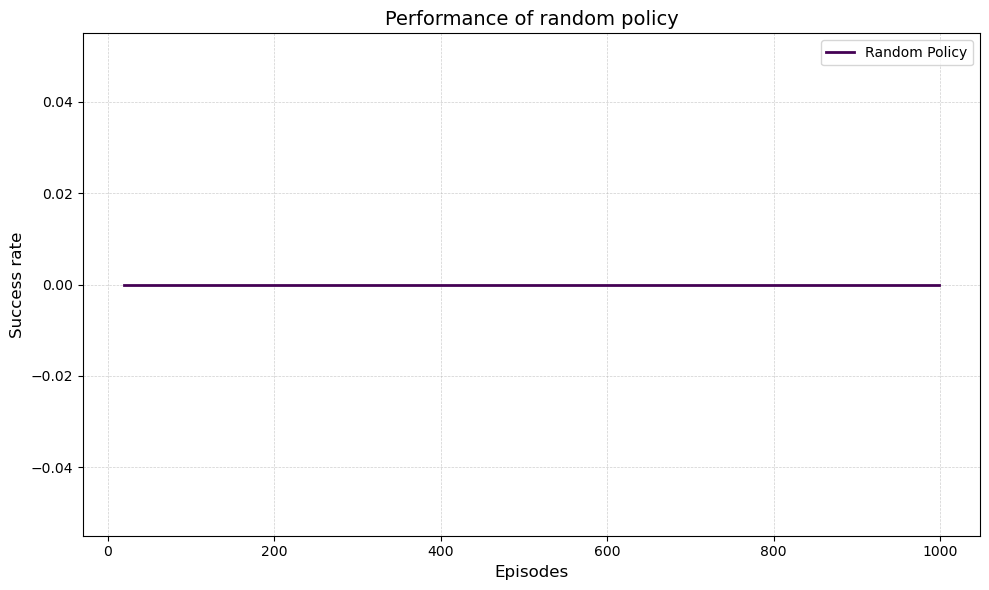

In [7]:
sm.visualizations.plot_moving_average([success],['Random Policy'],20,
                                      title='Performance of random policy', ylabel='Success rate')

# User Custom Policy (interacting with environment)

As the environment is deterministic, the optimal policy is: (0,1,1,1,1,1,1,1,1,1,1,1,2)

In [9]:
env = gym.make('CliffWalking-v0', render_mode='human', max_episode_steps=20)
state, _ = env.reset()
done = False

while not done:
    action = int(input('Select next action'))
    state, reward, terminated, truncated, info = env.step(action)
    env.render()
    
    done = sm.evaluate_done(terminated,truncated)

env.close()

# Q-Learning

### Hyperparameters

In [11]:
# Flexible Parameters (ipywidgets)
EPISODES_W = widgets.IntSlider(value=1000, min=50, max=5000, step=50, description='Number Episodes', 
                               style={'handle_color':'magenta','description_width':'initial'}, layout={'width': '40%'})

LEARNING_RATE_W = widgets.FloatSlider(value=0.1, min=0, max=1, step=0.05, description='Learning rate',
                                      style={'handle_color':'magenta','description_width':'initial'}, layout={'width': '40%'})
DISCOUNT_W = widgets.FloatSlider(value=0.95, min=0, max=1, step=0.05, description='Discount factor',
                                 style={'handle_color':'magenta','description_width':'initial'}, layout={'width': '40%'})

epsilon_W = widgets.FloatSlider(value=0.5, min=0, max=1, step=0.05, description='Exploration rate',
                                style={'handle_color':'magenta','description_width':'initial'}, layout={'width': '40%'})

display(EPISODES_W,LEARNING_RATE_W,DISCOUNT_W,epsilon_W)

START_EPSILON_DECAYING = 1                      # First episode at which decay epsilon

IntSlider(value=1000, description='Number Episodes', layout=Layout(width='40%'), max=5000, min=50, step=50, st…

FloatSlider(value=0.1, description='Learning rate', layout=Layout(width='40%'), max=1.0, step=0.05, style=Slid…

FloatSlider(value=0.95, description='Discount factor', layout=Layout(width='40%'), max=1.0, step=0.05, style=S…

FloatSlider(value=0.5, description='Exploration rate', layout=Layout(width='40%'), max=1.0, step=0.05, style=S…

## Training

In [12]:
env = gym.make('CliffWalking-v0', render_mode=None, max_episode_steps=16)

# Retrieving 
EPISODES = EPISODES_W.value; LEARNING_RATE = LEARNING_RATE_W.value
DISCOUNT = DISCOUNT_W.value; epsilon = epsilon_W.value
epsilon_decaying_value = epsilon / ((EPISODES//1.5) - START_EPSILON_DECAYING)     # Amount of decayment of epsilon    

# Generate the q_table 
q_table = sm.Q_Learning_Agent.generate_q_table('random',env.action_space.n,[env.observation_space.n],low=-2,high=0)

# Rewards
ep_rewards = list()
success = list()
epsilons = list()


### Training
for episode in range(EPISODES):
    
    episode_reward = 0
    state, info = env.reset()
    done = False
    
    while not done: 

        if np.random.random() > epsilon:                    # Randomize actions with epsilon
            action = np.argmax(q_table[state])              # Action taken from the argmax of the current state
        else:
            action = env.action_space.sample()              # Action taken at random
        
        new_state, reward, terminated, truncated, info = env.step(action)       # Retrieve information
        done = sm.evaluate_done(terminated,truncated)

        episode_reward += reward
        
        if not done: 
            q_table = sm.Q_Learning_Agent.update_q_table(q_table,(state,),(new_state,),action,reward,LEARNING_RATE,DISCOUNT)
        
        elif terminated:
            q_table[(state,) + (action, )] = 0        # Update value when goal is reached
        
        state = new_state                 # Update state
    
    epsilon = sm.Q_Learning_Agent.decay_epsilon(epsilon,episode,epsilon_decaying_value,START_EPSILON_DECAYING,EPISODES//1.5)
    
    ep_rewards.append(episode_reward)
    success.append(terminated)
    epsilons.append(epsilon)
     
env.close()

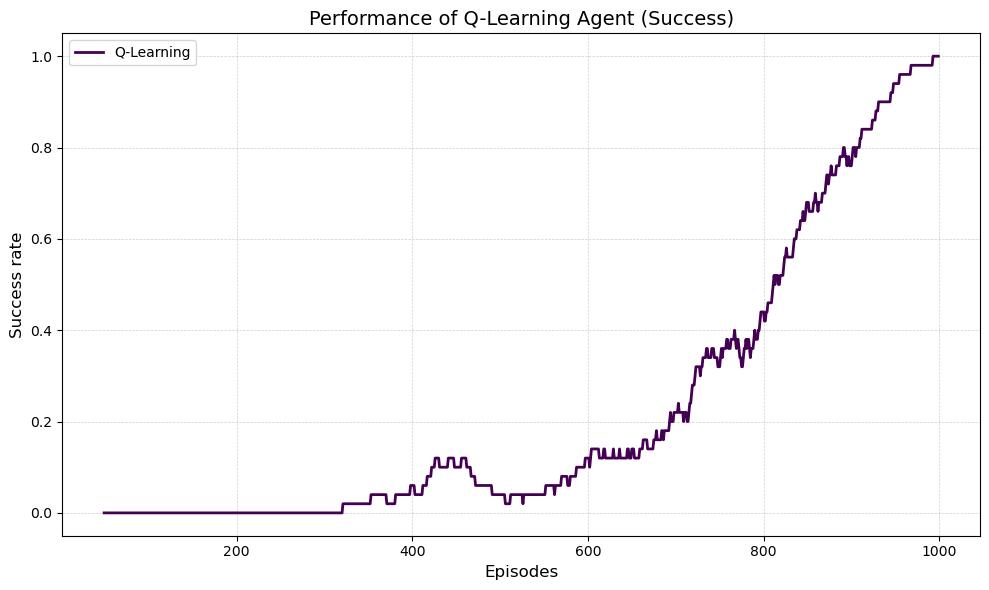

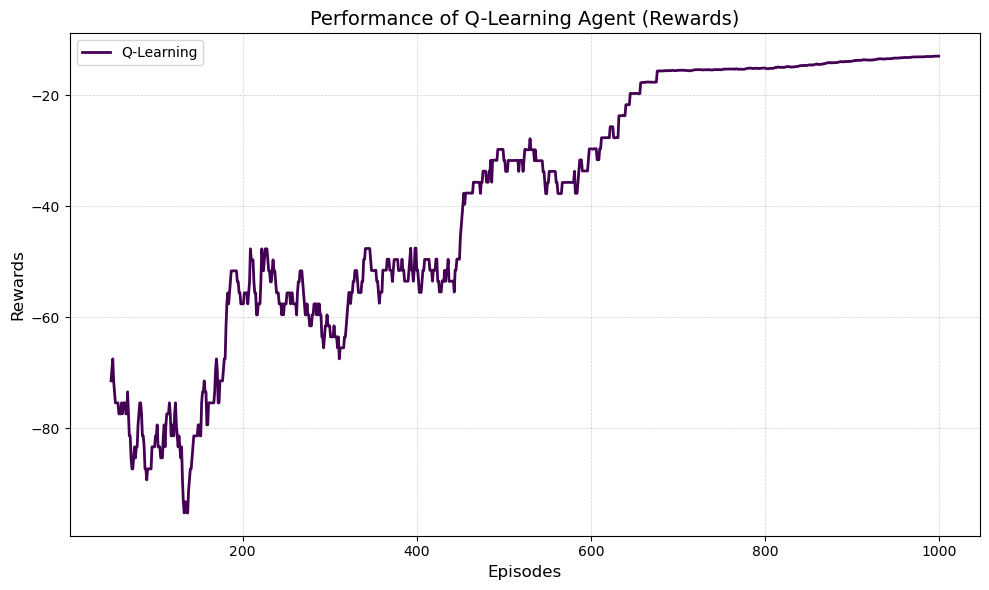

In [13]:
# Visualizing training results
sm.visualizations.plot_moving_average([success],['Q-Learning'],50,
                                      title='Performance of Q-Learning Agent (Success)',ylabel='Success rate')
sm.visualizations.plot_moving_average([ep_rewards],['Q-Learning'],50,
                                      title='Performance of Q-Learning Agent (Rewards)',ylabel='Rewards')

## Testing

### Visualizing Trained Agent

In [53]:
env = gym.make('CliffWalking-v0', render_mode='human', max_episode_steps=16)
state, _ = env.reset()
done = False

while not done:
    action = np.argmax(q_table[state])
    state, reward, terminated, truncated, info = env.step(action)
    env.render()
    
    done = sm.evaluate_done(terminated,truncated)

env.close()

### Testing Agent on 100 New Episodes

In [14]:
env = gym.make('CliffWalking-v0', render_mode=None, max_episode_steps=16)
testing_success = list()
testing_rewards = list()

for episode in range(100):
    state, _ = env.reset()
    done = False
    ep_reward = 0

    while not done:
        action = np.argmax(q_table[state])
        state, reward, terminated, truncated, info = env.step(action)

        ep_reward += reward
        
        done = sm.evaluate_done(terminated,truncated)

    testing_success.append(terminated)
    testing_rewards.append(ep_reward)
env.close()

print(f'Success rate of Q-Learning Agent on 100 episodes: {round(sum(testing_success)/len(testing_success),2)}')
print(f'Average rewards of Q-Learning Agent on 100 episodes: {round(sum(testing_rewards)/len(testing_rewards),2)}')

Success rate of Q-Learning Agent on 100 episodes: 1.0
Average rewards of Q-Learning Agent on 100 episodes: -13.0
